Programming Exercise 2: Logistic Regression

In [1]:
%matplotlib inline
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy

# Logistic Regression

## Load & Process dataset

###### load shape : (m , n)

In [2]:
dataset = 'dataset/ex2data1.txt'
ori_data = np.loadtxt(dataset, delimiter=',')
print("> ori_data.shape", ori_data.shape)
print("\n> ori_data[:5]\n", ori_data[:5])

> ori_data.shape (100, 3)

> ori_data[:5]
 [[34.62365962 78.02469282  0.        ]
 [30.28671077 43.89499752  0.        ]
 [35.84740877 72.90219803  0.        ]
 [60.18259939 86.3085521   1.        ]
 [79.03273605 75.34437644  1.        ]]


###### get ori Matrix-X, Vector-y
> + X_ori : (m, n)
> + y_ori : (m, )

In [3]:
def get_ori_X_y(ori, method=0):
    m = ori.shape[0]
    size = ori.shape[1]
    
    if method == 0:          # Python Slice [通用]
        X_ori = np.array(ori[:,:-1])
        y_ori = np.array(ori[:,-1:]).reshape((-1,))
    elif method == 1:        # np.reshape() [通用]   
        X_ori = np.array(ori[:,:size-1]).reshape((-1,size-1))
        y_ori = np.array(ori[:,-1:]).reshape((-1,))

    print("> X_ori.shape : ", X_ori.shape)
    print("> y_ori.shape : ", y_ori.shape)
    print("> Sample : ", m)
    
    return X_ori, y_ori, m

X_ori, y_ori, m = get_ori_X_y(ori_data)

> X_ori.shape :  (100, 2)
> y_ori.shape :  (100,)
> Sample :  100


###### Feature Normalization

In [4]:
A = np.arange(0, 12).reshape((3,4))
print(np.mean(A, axis = 0))
print(np.mean(A, axis = 1))

[4. 5. 6. 7.]
[1.5 5.5 9.5]


In [6]:
mu_train = 0
std_train = 0
def feature_normalization(X):
    global mu_train, std_train
    
    mu_train = np.mean(X, axis=0)
    std_train = np.std(X, axis=0)
    X_norm =  (X - mu_train) / std_train
    
    return X_norm

X_norm = feature_normalization(X_ori)
print(mu_train)
print(std_train)

[65.64427406 66.22199809]
[19.36068671 18.48963567]


In [7]:
X_norm[:3]

array([[-1.60224763,  0.63834112],
       [-1.82625564, -1.2075414 ],
       [-1.53903969,  0.3612943 ]])

###### Form Trainning Data
> + X_train : (m, n+1)
> + y_train : (m, )

In [7]:
def form_train_data(X_ori, y_ori, method=0):
    y_train = y_ori
    
    if method == 0:          # np.insert(obj, pos, val, axis=？)
        X_train = np.insert(X_ori, 0, 1, axis=1)
    elif method == 1:        # np.hstack()
        ones = np.ones((X_ori.shape[0],1))
        X_train = np.hstack((ones, X_ori))
    elif method == 2:        # np.c_[]
        #ones = np.ones((m,1))
        ones = np.ones(y_ori.shape)
        X_train = np.c_[ones, X_ori]
    
    print("> X_train.shape", X_train.shape)
    print("> X_train[:3]\n", X_train[:3])
    
    return X_train, y_train


X_train, y_train = form_train_data(X_ori, y_ori)

> X_train.shape (100, 3)
> X_train[:3]
 [[ 1.         34.62365962 78.02469282]
 [ 1.         30.28671077 43.89499752]
 [ 1.         35.84740877 72.90219803]]


### Plot Orignial Data

###### method - 01 : split data to two array, pos & neg

In [8]:
def distinguish_X(X_ori, y_ori):
    pos = np.array([X_ori[i] for i in range(X_ori.shape[0]) if y_ori[i] == 1])
    neg = np.array([X_ori[i] for i in range(X_ori.shape[0]) if y_ori[i] == 0])
    print("pos.shape", pos.shape)
    print("neg.shape", neg.shape)
    print(pos[:3])
    return pos, neg

def plot_ori_data(X_ori, y_ori):
    pos, neg = distinguish_X(X_ori, y_ori)
    
    plt.figure(figsize=(9, 6))
    plt.plot(pos[:,0], pos[:,1], 'k+', label='    Admitted - Pos')
    plt.plot(neg[:,0], neg[:,1], 'yo', label='Not admitted - Neg')

    plt.xlabel('Exam 1 Score')
    plt.ylabel('Exam 2 Score')

    plt.legend()
    plt.grid(True)

#plot_ori_data(X_ori, y_ori)

###### method - 02 : output two bool arrays

In [9]:
neg = (ori_data[:,2] == 0)

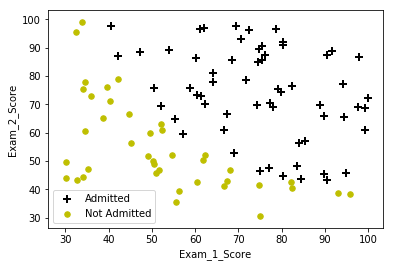

In [10]:
def plot_ori_data(data, label_x1, label_x2, label_pos, label_neg, axes=None):
    # split data to two bool arrays
    neg = (data[:,-1] == 0)
    pos = (data[:,-1] == 1)
    
    # Does Already have a axes
    if axes == None:
        axes = plt.gca()
    
    axes.scatter(data[pos][:,0], data[pos][:,1], c='k', s=50, marker='+', linewidth=2, label=label_pos)
    axes.scatter(data[neg][:,0], data[neg][:,1], c='y', s=30, label=label_neg)
    axes.set_xlabel(label_x1)
    axes.set_ylabel(label_x2)
    axes.legend()

plot_ori_data(ori_data, 'Exam_1_Score', 'Exam_2_Score', 'Admitted', 'Not Admitted')

###### method - 03 :

In [11]:
np.where(ori_data[:,-1] == 1)

(array([ 3,  4,  6,  7,  8,  9, 12, 13, 15, 16, 18, 19, 21, 24, 25, 26, 30,
        31, 33, 37, 40, 42, 46, 47, 48, 49, 50, 51, 52, 56, 58, 59, 60, 66,
        68, 69, 71, 72, 73, 74, 75, 76, 77, 80, 81, 82, 83, 84, 85, 87, 88,
        90, 91, 93, 94, 95, 96, 97, 98, 99]),)

In [12]:
pos = (np.where(ori_data[:, -1] == 1))
neg = (np.where(ori_data[:, -1] == 0))
ori_data[pos][:5]
#ori_data[pos， 0] - scatter

array([[60.18259939, 86.3085521 ,  1.        ],
       [79.03273605, 75.34437644,  1.        ],
       [61.10666454, 96.51142588,  1.        ],
       [75.02474557, 46.55401354,  1.        ],
       [76.0987867 , 87.42056972,  1.        ]])

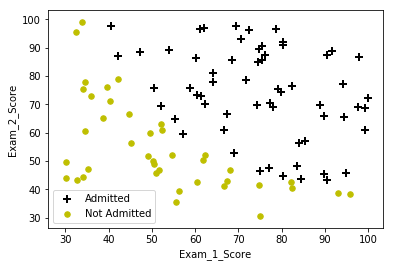

In [13]:
def plot_ori_data(data, label_x1, label_x2, label_pos, label_neg, axes=None):
    # split data to two index arrays
    pos = (np.where(ori_data[:, -1] == 1))
    neg = (np.where(ori_data[:, -1] == 0))
    
    # Does Already have a axes
    if axes == None:
        axes = plt.gca()
    
    axes.scatter(data[pos, 0], data[pos, 1], c='k', s=50, marker='+', linewidth=2, label=label_pos)
    axes.scatter(data[neg, 0], data[neg, 1], c='y', s=30, label=label_neg)
    axes.set_xlabel(label_x1)
    axes.set_ylabel(label_x2)
    axes.legend()

plot_ori_data(ori_data, 'Exam_1_Score', 'Exam_2_Score', 'Admitted', 'Not Admitted')

In [14]:
###### method - 04 : pandas

In [15]:
# positive = data[data['Admitted'].isin([1])]
# negative = data[data['Admitted'].isin([0])]

## Logistic Regression

### Sigmod

+ $ g(z)=\frac{1}{1+e^{−z}} $
> + Z - (m, 1)
> + (m,)

In [16]:
def sigmoid(Z, method=1):
    if method == 0:
        g = sigmoid_exp(Z)
    elif method == 1:
        g = sigmoid_expit(Z)
    
    return g

###### method 01 : np.exp( )

In [17]:
def sigmoid_exp(Z):
    return (1.0 / (1 + np.exp(-Z)))
    
"""
import decimal
decimal.getcontext().prec = 50
def sigmod(Z):
    #z = np.array([x.astype(np.float64) for x in Z])
    z = np.array([x.astype(decimal.Decimal) for x in Z])
    g = 1.0 / (1 + np.exp(-Z))
    return g
"""

'\nimport decimal\ndecimal.getcontext().prec = 50\ndef sigmod(Z):\n    #z = np.array([x.astype(np.float64) for x in Z])\n    z = np.array([x.astype(decimal.Decimal) for x in Z])\n    g = 1.0 / (1 + np.exp(-Z))\n    return g\n'

###### method 02 : scipy.special.expit()

Scipy actually has a convenience function which does exactly the same:<BR>
http://docs.scipy.org/doc/scipy/reference/generated/scipy.special.expit.html#scipy.special.expit

In [18]:
def sigmoid_expit(Z):
    return scipy.special.expit(Z)

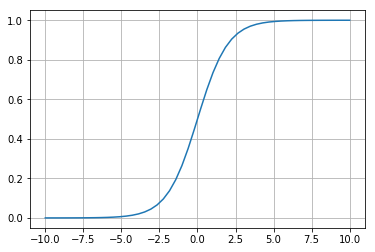

In [19]:
def plot_sigmoid():
    #X = np.arange(-10, 10, 1)
    X = np.linspace(-10, 10 ,50)
    plt.plot(X, sigmoid(X, 0))
    plt.grid(True)

plot_sigmoid()

### Hypthesis

+ $ h_{\theta}(x) = g(\theta^{T}x)$
> + theta - (n+1, 1)
> + X - (m, n+1)
> + (m,)

In [20]:
def hypthesis(theta, X):
    hyp = sigmoid(X @ theta)
    
    return hyp

### Cost Function

+ Normal : $ J\left( \theta  \right)=-\frac{1}{m}\sum\limits_{i=1}^{m}{[{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)+\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]} $
+ Vector : $ J(\theta) = -\frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big) $
> + theta - (n+1, )
> + X - (m, n+1)
> + y - (m, )
> + scalars

In [21]:
J_history = []
def cost_function_simple(theta, X, y):
    hyp = hypthesis(theta, X)
    y_1 = np.log(hyp).T @ y
    y_0 = np.log(1 - hyp).T @ (1-y)
    cost = -(y_1 + y_0) / y.size
    
    return cost

#===========================================
def replaceZeroes(data):
    #print(data)
    if np.count_nonzero(data):
        min_nonzero = np.min(data[np.nonzero(data)])
    else:
        min_nonzero = 0.000000000001
    data[data == 0] = min_nonzero
    return data

def cost_function_complex(theta, X, y):
    global J_history_opt
    
    m = y.size
    hyp = hypthesis(theta, X) # (m,1)
    hyp_01 = replaceZeroes(hyp)
    #print("------------")
    #print(hyp)
    #print(y)
    hyp_02 = replaceZeroes(1.0-hyp)
    #hyp_02 = 1-hyp
    first  = np.dot(np.log(hyp_01).T, -y) # (1,1)
    second = np.dot(np.log(hyp_02).T, (1.0-y))
    
    J = (first - second) / float(m)
    J_history_opt.append(J)
    
    return J

In [22]:
def cost_function(theta, X, y, method=0):
    global J_history
    
    if method == 0:
        cost = cost_function_simple(theta, X, y)
    elif method == 1:
        cost = cost_function_complex(theta, X, y)
    
    J_history.append(cost)
    # print(">>", J_history)
    return cost
'''
    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])
'''
    

theta = np.zeros((X_train.shape[1],))
cost_function(theta, X_train, y_train, 0)

0.6931471805599452

### Gradient Descent

+ Normal : $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} $$ 
+ Vector : $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y)$$
+ $ {{\theta }_{j}}:={{\theta }_{j}} - {{a} * {Gradient}} $
+ $ {Gradient} = \frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{j}^{(i)}}$
> + theta - (n+1, )
> + X - (m, n+1)
> + y - (m, )
> + (n+1, )

In [23]:
def gradient(theta, X, y):
    err = hypthesis(theta, X) - y
    grad = (X.T @ err) / m
    
    return grad

theta = np.zeros((X_train.shape[1],))
gradient(theta, X_train, y_train)

array([ -0.1       , -12.00921659, -11.26284221])

### Optimize

In [24]:
# use fminunc
# most loop for 400 steps
# cost about 0.203

#### Scipy

In [25]:
def scipy_opt_minimize(theta, X, y, Method):
    res = opt.minimize(
        fun    = cost_function,
        x0     = theta,
        args   = (X, y),
        method = Method,
        jac    = gradient # , options={'maxiter':400}
    )
    
    return {
        "result" : res,
        "theta" : res.x
    }

theta = np.zeros((X_train.shape[1],))
res = scipy_opt_minimize(theta, X_train, y_train, "tnc")
print(res)

cost_function(res['theta'], X_train, y_train)
theta_scipty = res['theta']

{'result':      fun: 0.20349770158947536
     jac: array([9.09409796e-09, 9.53481005e-08, 4.73354162e-07])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 36
     nit: 17
  status: 0
 success: True
       x: array([-25.16131843,   0.20623159,   0.20147148]), 'theta': array([-25.16131843,   0.20623159,   0.20147148])}


In [26]:
def scipy_opt_fmin(theta, X, y):
    opt.fmin(
        fun = cost_function,
        x0 = theta,
        args = (X, y),
    )
    
    opt.fmin_cg(
        f = cost_function,
        x0 = theta,
        fprime = gradient,
        args = (X, y)
    )
    
    opt.fmin_bfgs(
        f = cost_function,
        x0 = theta,
        fprime = gradient,
        args = (X, y),   
    )
    
    opt.fmin_tnc(
        func = cost_function,
        x0 = theta,
        fprime = gradient,
        args = (X, y)
    )

In [27]:
'''
theta, theta_i = fmin_bfgs(costFunction,inTheta,fprime = gradient,args=(X,y),retall = 1, disp = 0)

J = zeros(len(theta_i))
for i,th in enumerate(theta_i):
    J[i] = costFunction(th,X,y)  
plot(J)


print 'The optimize values for Theta are: %s '%theta

acc = accuracy(theta,X,y)
print 'The Accuracy of the algorithm is: %f' %acc
'''

"\ntheta, theta_i = fmin_bfgs(costFunction,inTheta,fprime = gradient,args=(X,y),retall = 1, disp = 0)\n\nJ = zeros(len(theta_i))\nfor i,th in enumerate(theta_i):\n    J[i] = costFunction(th,X,y)  \nplot(J)\n\n\nprint 'The optimize values for Theta are: %s '%theta\n\nacc = accuracy(theta,X,y)\nprint 'The Accuracy of the algorithm is: %f' %acc\n"

#### Sklearn

In [28]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty="l2", C=10000, fit_intercept=False, multi_class='ovr')
model.fit(X_train, y_train)
print("> model.intercept_", model.intercept_)
print("> model.coef_", model.coef_)

cost_function(model.coef_.T, X_train, y_train)

> model.intercept_ 0.0
> model.coef_ [[-24.87970176   0.20397944   0.19919232]]


array([0.20350961])

In [29]:
model.score(X_train, y_train)

0.89

#### Batch Gradient Descent

In [30]:
def batch_gradient_descent(theta, X, y, lr=0.009, iterations=1500):
    global J_history
    J_history = []
    
    for _ in range(iterations):
        grad = gradient(theta, X, y)
        theta = theta - lr * grad
        cost = cost_function(theta, X, y)
    cost = cost_function(theta, X, y)
    return theta, cost

theta = np.zeros((X_train.shape[1],))
res = batch_gradient_descent(theta, X_train, y_train, lr =0.0007, iterations=1000)  #1700000)
print(res)

(array([-0.04865855,  0.01076291,  0.00082964]), 0.6264279283330879)


## Predict && Accuary

In [31]:
# predict - (45,85) - 0.776

In [32]:
def predict(theta, X, threshold=0.5):
    #print(X)
    hyp = hypthesis(theta, X)
    pred = (hyp >= threshold).astype('int')
    
    return pred

'''
pred_data = np.array([[1, 45, 85]])
hyp = hypthesis(theta_BFGS, pred_data)
prd = predict(theta_BFGS, pred_data)
print('Hyp - ', hyp)
print('Prd - ', prd)
'''

"\npred_data = np.array([[1, 45, 85]])\nhyp = hypthesis(theta_BFGS, pred_data)\nprd = predict(theta_BFGS, pred_data)\nprint('Hyp - ', hyp)\nprint('Prd - ', prd)\n"

In [33]:
'''
def predict(theta, X):
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]
'''

'\ndef predict(theta, X):\n    probability = sigmoid(X * theta.T)\n    return [1 if x >= 0.5 else 0 for x in probability]\n'

In [34]:
def accuracy(theta, X, y, threshold=0.5):
    pred = predict(theta, X, threshold)
    accuracy = np.mean(pred == y)
    return accuracy

accu = accuracy(theta_scipty, X_train, y_train)
print(accu)
# print('Train accuracy {}%'.format(100*sum(p == y.ravel())/p.size))

0.89


In [35]:
from sklearn.metrics import classification_report
y_pred = predict(theta_scipty, X_train)
result = classification_report(y_train, y_pred)
print(result)

             precision    recall  f1-score   support

        0.0       0.87      0.85      0.86        40
        1.0       0.90      0.92      0.91        60

avg / total       0.89      0.89      0.89       100



## Plot Convetgence Curves

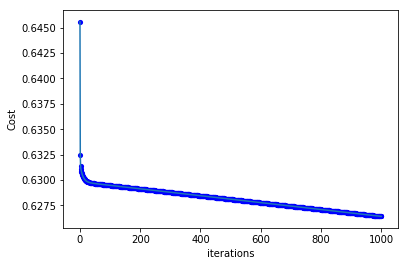

In [36]:
def plot_convergence_curves(J_history, axes=None):   
    # Does Already have a axes
    if axes == None:
        axes = plt.gca()
    
    axes.plot(np.arange(len(J_history)), J_history)
    axes.scatter(np.arange(len(J_history)), J_history, c='b', s=10, linewidth=2)
    axes.set_xlabel("iterations")
    axes.set_ylabel("Cost")

#plt.subplot(221)
plot_convergence_curves(J_history)
#plt.subplot(222)
#plot_convergence_curves(J_history)

## Plot Decision Boundary

http://stats.stackexchange.com/questions/93569/why-is-logistic-regression-a-linear-classifier
> $X \times \theta = 0$  (this is the line)

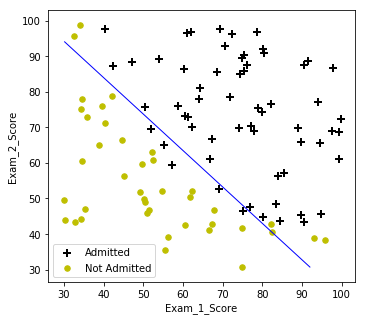

In [37]:
def plot_decision_boundary(data, theta, axes=None):
    X1_min, X1_max = data[:,0].min(), data[:,0].max()
    X2_min, X2_max = data[:,1].min(), data[:,1].max()

    xx1, xx2 = np.meshgrid(np.linspace(X1_min, X1_max), np.linspace(X2_min, X2_max))


    Countour_X = np.c_[np.ones((xx1.ravel().size,1)), xx1.ravel().reshape(-1,1), xx2.ravel().reshape(-1,1)]
    #ps('theta', theta)
    #print('Countour_X',Countour_X)
    
    hyp = hypthesis(theta, Countour_X).reshape(xx1.shape)
    
    axes.contour(xx1, xx2, hyp, [0.5], linewidths=1, colors='b')
    

plt.figure(figsize=(5.5,5))
plot_ori_data(ori_data, 'Exam_1_Score', 'Exam_2_Score', 'Admitted', 'Not Admitted', axes=plt.gca())
plot_decision_boundary(ori_data, theta_scipty, axes=plt.gca())

In [38]:
def plot_predict_data():
    plt.scatter(pred_data[:,1], pred_data[:,2], s=60, c='r', marker='v', label='(45, 85) : Pred as %d'%(pred))
    plt.legend()
    pass

pred_data = np.array([[1, 45, 70]])

# Regularized Logistic Regression

## Load & Process dataset

In [39]:
dataset_02 = 'dataset/ex2data2.txt'
ori_data_02 = np.loadtxt(dataset_02, delimiter=',')
print("> ori_data_02.shape", ori_data_02.shape)
print("\n> ori_data_02[:5]\n", ori_data_02[:5])

> ori_data_02.shape (118, 3)

> ori_data_02[:5]
 [[ 0.051267  0.69956   1.      ]
 [-0.092742  0.68494   1.      ]
 [-0.21371   0.69225   1.      ]
 [-0.375     0.50219   1.      ]
 [-0.51325   0.46564   1.      ]]


In [40]:
X_ori_02, y_ori_02, m_02 = get_ori_X_y(ori_data_02)

> X_ori.shape :  (118, 2)
> y_ori.shape :  (118,)
> Sample :  118


In [41]:
X_train_02, y_train_02 = form_train_data(X_ori_02, y_ori_02)

> X_train.shape (118, 3)
> X_train[:3]
 [[ 1.        0.051267  0.69956 ]
 [ 1.       -0.092742  0.68494 ]
 [ 1.       -0.21371   0.69225 ]]


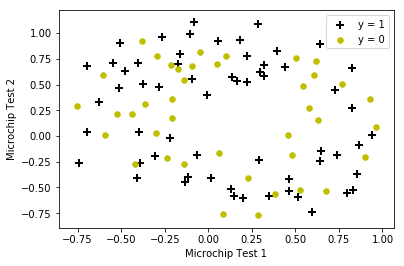

In [42]:
plot_ori_data(ori_data_02, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')

## Feature Mapping

<img style="float: left;" src="dataset/mapped_feature.png">

### Polynomials

In [43]:
from sklearn.preprocessing import PolynomialFeatures

In [44]:
poly = PolynomialFeatures(6)

In [45]:
ori_data_02.shape

(118, 3)

In [46]:
X_train_poly = poly.fit_transform(X_ori_02)
print('X_train_poly.shape', X_train_poly.shape)

X_train_poly.shape (118, 28)


In [47]:
import pandas as pd
XX_df = pd.DataFrame(X_train_poly, columns=poly.get_feature_names())
XX_df.head()

,1,x0,x1,x0^2,x0 x1,x1^2,x0^3,x0^2 x1,x0 x1^2,x1^3,...,x0^2 x1^3,x0 x1^4,x1^5,x0^6,x0^5 x1,x0^4 x1^2,x0^3 x1^3,x0^2 x1^4,x0 x1^5,x1^6
0,1.0,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,0.342354,...,0.000900,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206
1,1.0,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,0.321335,...,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1.0,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,0.331733,...,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1.0,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,0.126650,...,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1.0,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,0.100960,...,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


## Regularization Logistic Regression

### Regularized Cost Function

In [48]:
# cost_reg -> 0.693

+ Normal : $ J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]} + \frac{\lambda }{2m}\sum\limits_{j=1}^{n}{{\theta }_{j}^{2}} $
+ Vector : $ J(\theta) = -\frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big) + \frac{\lambda }{2m}\sum\limits_{j=1}^{n}{{\theta }_{j}^{2}} $
> + theta - (n+1, )
> + X - (m, n+1)
> + y - (m, )
> + (1, 1)

In [49]:
J_history_reg = []
def cost_function_reg(theta, X, y, lamd = 0):
    global J_history_reg
    
    cost = cost_function(theta, X, y)
    reg_item = lamd * (theta[1:].T @ theta[1:]) / (2 * m)
    cost_reg = cost + reg_item
    
    J_history_reg.append(cost_reg)
    
    return cost_reg

theta_init = np.zeros((X_train_poly.shape[1],))
cost_function_reg(theta_init, X_train_poly, y_train_02, lamd = 1)

0.6931471805599453

### Regrlarized Gradient Descent

#### Partial derivative

#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} + \frac{\lambda}{m}\theta_{j}$$ 
#### Vectorized
#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y) + \frac{\lambda}{m}\theta_{j}$$
##### $$\text{Note: intercept parameter } \theta_{0} \text{ is not to be regularized}$$

+ $ {{\theta }_{0}}:={{\theta }_{0}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{_{0}}^{(i)}} $
+ $ {{\theta }_{j}}:={{\theta }_{j}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{j}^{(i)}}+\frac{\lambda }{m}{{\theta }_{j}} $
> + theta - (n+1, )
> + X - (m, n+1)
> + y - (m, )
> + (n+1, )

In [50]:
def gradient_reg(theta, X, y, lamd=0):
    grad = gradient(theta, X, y)
    reg_theta = lamd * theta[1:] / m
    reg_item = np.r_[[0], reg_theta]
    
    grad_reg = grad + reg_item
    
    return grad_reg

theta_init = np.zeros((X_train_poly.shape[1],))
gradient_reg(theta_init, X_train_poly, y_train_02, lamd=1)

array([1.00000000e-02, 2.21699500e-02, 9.17700000e-05, 5.94066747e-02,
       1.35715703e-02, 4.44445199e-02, 2.16600649e-02, 8.64224202e-03,
       9.66708473e-03, 2.77022569e-02, 4.64313757e-02, 2.64230210e-03,
       1.51748594e-02, 3.65320590e-03, 4.63773242e-02, 2.35654811e-02,
       5.10920214e-03, 3.99599804e-03, 6.88910052e-03, 5.28202298e-03,
       3.65894222e-02, 3.66168682e-02, 1.29493481e-03, 7.45253540e-03,
       4.82033547e-04, 8.57275093e-03, 1.62422486e-03, 4.57764909e-02])

### Regularized Optimize

#### Scipy

In [51]:
def scipy_opt_minimize_reg(theta, X, y, Method, lamd=0):
    res = opt.minimize(
        fun    = cost_function_reg,
        x0     = theta,
        args   = (X, y, lamd),
        method = Method,
        jac    = gradient_reg
    )
    
    return {
        "result" : res,
        "theta" : res.x
    }

lamd = 1 / 10000
theta_init = np.zeros((X_train_poly.shape[1],))
res = scipy_opt_minimize_reg(theta_init, X_train_poly, y_train_02, "tnc", lamd)
print(res)

print()
print(cost_function_reg(theta_init, X_train_poly, y_train_02, lamd))
print(cost_function_reg(res['theta'], X_train_poly, y_train_02, lamd))
theta_scipy_reg = res['theta']

{'result':      fun: 0.28724844245174935
     jac: array([ 8.86080553e-05, -1.43096833e-05,  1.46591727e-05,  1.54446684e-05,
       -1.99433788e-05,  3.09617058e-05, -3.72107747e-06,  7.16395461e-07,
       -3.80750979e-06,  1.25599589e-06,  9.06222707e-06, -5.66420870e-07,
        1.27092152e-06, -1.24258160e-05,  2.75516440e-05, -9.88203518e-08,
        2.47830803e-07,  4.67027180e-07,  2.24746446e-06, -3.30401327e-06,
        1.69354629e-05,  6.25441503e-06,  1.20587401e-06, -2.59327316e-07,
       -6.38108294e-07,  1.99822073e-06, -4.78638379e-06,  2.06657721e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 280
     nit: 22
  status: 3
 success: False
       x: array([  3.08317484,  -0.75659766,   2.92301711, -12.96145782,
        -9.00944053,   5.25706978,   2.45603135,  15.70680452,
        27.05563204,   1.98245823,  44.27748483,  11.01008815,
        -5.92753003,  -5.75413442, -33.28974635,  10.35821496,
        -7.47102465,  -4.28485336, -14.22688186, -

In [52]:
def scipy_opt_fmin_reg(theta, X, y):
    opt.fmin(
        fun = cost_function,
        x0 = theta,
        args = (X, y),
    )
    
    opt.fmin_cg(
        f = cost_function,
        x0 = theta,
        fprime = gradient,
        args = (X, y)
    )
    
    opt.fmin_bfgs(
        f = cost_function,
        x0 = theta,
        fprime = gradient,
        args = (X, y),   
    )
    
    opt.fmin_tnc(
        func = cost_function,
        x0 = theta,
        fprime = gradient,
        args = (X, y)
    )

#### Sklearn

In [53]:
# from sklearn.linear_model import LogisticRegression
model_reg = LogisticRegression(penalty="l2", C=10000, fit_intercept=False, multi_class='ovr')
print(model_reg.fit(X_train_poly, y_train_02))
print("> model_reg.intercept_", model_reg.intercept_)
print("> model_reg.coef_", model_reg.coef_)

cost_function_reg(model_reg.coef_.T, X_train_poly, y_train_02, 1 / 10000)

LogisticRegression(C=10000, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
> model_reg.intercept_ 0.0
> model_reg.coef_ [[  3.02935115  -0.80372003   2.59303057 -12.70970105  -9.27490898
    5.47830677   2.52759111  16.48811663  27.54612797   3.77993264
   43.95443389  11.46367536  -6.18491181  -4.57352495 -34.18267104
   10.45228977  -7.7763198   -4.87431702 -16.27131298 -17.80192293
   11.94256807 -72.45154062 -36.40082464 -12.58889675  28.65658599
  -51.74319301 -36.94137618   2.01963105]]


array([[0.28724761]])

In [54]:
model_reg.score(X_train_poly, y_train_02)

0.864406779661017

#### Batch Gradient Descent

In [55]:
def batch_gradient_descent_reg(theta, X, y, lr=0.009, iterations=1500, lamd = 0):
    for _ in range(iterations):
        grad_reg = gradient_reg(theta, X, y, lamd)
        theta = theta - lr * grad_reg
    cost = cost_function_reg(theta, X, y, lamd)
    return theta, cost

theta_init = np.zeros((X_train_poly.shape[1],))
res = batch_gradient_descent_reg(theta_init, X_train_poly, y_train_02, iterations=1000, lamd=10)
print(res)

(array([ 0.15216518, -0.04732177,  0.08766342, -0.27651519, -0.07349812,
       -0.16820815, -0.0708825 , -0.03714278, -0.04379026, -0.08609871,
       -0.2210009 , -0.01092939, -0.0726057 , -0.0190421 , -0.19378532,
       -0.09344144, -0.02402993, -0.01640575, -0.03176038, -0.02655684,
       -0.14168817, -0.17242348, -0.00399397, -0.03672589, -0.00125678,
       -0.04090365, -0.00831238, -0.19387313]), 0.6560467331570089)


# Plot Regularize Decision Boundary

In [56]:
def plot_decision_boundary(data, theta, axes=None, lamd=0):
    X1_min, X1_max = data[:,0].min(), data[:,0].max()
    X2_min, X2_max = data[:,1].min(), data[:,1].max()

    xx1, xx2 = np.meshgrid(np.linspace(X1_min, X1_max), np.linspace(X2_min, X2_max))
    XX = poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()])
    hyp = hypthesis(theta, XX).reshape(xx1.shape)
    print(">> XX.shape :", XX.shape)
    print(">> hyp.shape :", hyp.shape)
    cont = axes.contour(xx1, xx2, hyp, [0.5], linewidths=1, colors='b')
    axes.clabel(cont, inline=True, colors='r', fontsize=15, fmt=('lambda = %d' %lamd))

>> XX.shape : (2500, 28)
>> hyp.shape : (50, 50)
[  3.08317484  -0.75659766   2.92301711 -12.96145782  -9.00944053
   5.25706978   2.45603135  15.70680452  27.05563204   1.98245823
  44.27748483  11.01008815  -5.92753003  -5.75413442 -33.28974635
  10.35821496  -7.47102465  -4.28485336 -14.22688186 -16.91708105
  14.41734706 -72.32820637 -35.90830642 -13.00632745  29.29202177
 -51.81415044 -35.90091905   0.3460477 ]


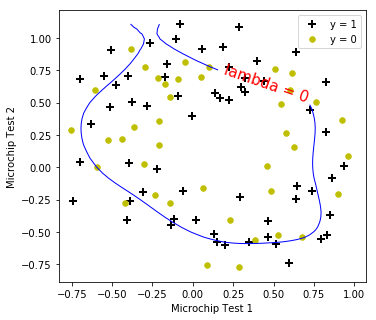

In [57]:
plt.figure(figsize=(5.5,5))
plot_ori_data(ori_data_02, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')
plot_decision_boundary(ori_data_02, theta_scipy_reg, axes=plt.gca())
print(theta_scipy_reg)

In [58]:
lamd = [0, 1, 100]
theta_init = np.zeros((X_train_poly.shape[1],))
res_0   = scipy_opt_minimize_reg(theta_init, X_train_poly, y_train_02, "tnc", lamd[0])
res_1   = scipy_opt_minimize_reg(theta_init, X_train_poly, y_train_02, "tnc", lamd[1])
res_100 = scipy_opt_minimize_reg(theta_init, X_train_poly, y_train_02, "tnc", lamd[1])
theta_scipy_reg_0   = res_0['theta']
theta_scipy_reg_1   = res_1['theta']
theta_scipy_reg_100 = res_100['theta']

>> XX.shape : (2500, 28)
>> hyp.shape : (50, 50)
>> XX.shape : (2500, 28)
>> hyp.shape : (50, 50)
>> XX.shape : (2500, 28)
>> hyp.shape : (50, 50)


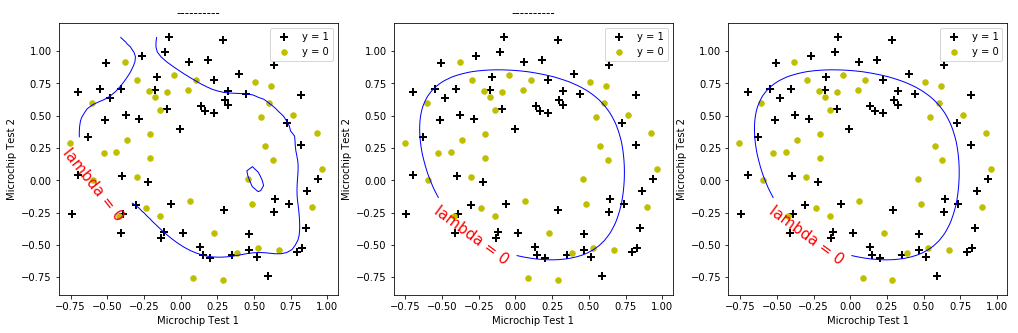

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(17,5))
axes_0 = axes.flatten()[0]
axes_0.set_title("----------")
plot_ori_data(ori_data_02, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0', axes_0)
plot_decision_boundary(ori_data_02, theta_scipy_reg_0, axes_0)

axes_1 = axes.flatten()[1]
axes_1.set_title("----------")
plot_ori_data(ori_data_02, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0', axes_1)
plot_decision_boundary(ori_data_02, theta_scipy_reg_1, axes_1)

axes_100 = axes.flatten()[2]
#axes_100.set_title('Train accuracy {}% with Lambda = {}'.format(np.round(accuracy, decimals=2), C))
plot_ori_data(ori_data_02, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0', axes_100)
plot_decision_boundary(ori_data_02, theta_scipy_reg_100, axes_100)

0
>> XX.shape : (2500, 28)
>> hyp.shape : (50, 50)
1
>> XX.shape : (2500, 28)
>> hyp.shape : (50, 50)
100
>> XX.shape : (2500, 28)
>> hyp.shape : (50, 50)


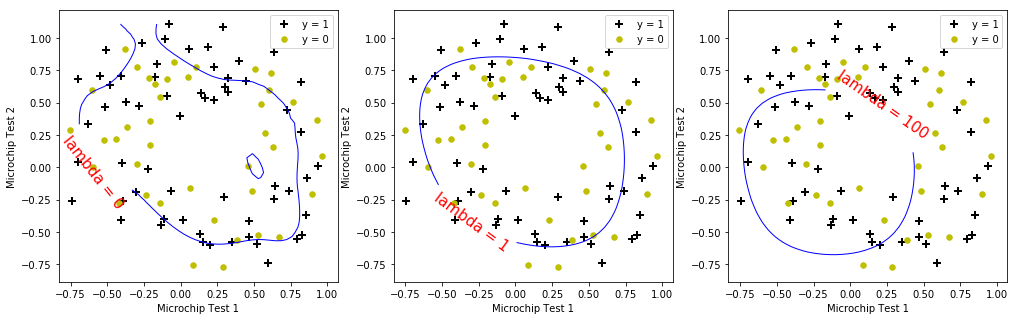

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(17,5))
theta_init = np.zeros((X_train_poly.shape[1],))

for i, C in enumerate([0, 1, 100]):
    print(C)
    res = scipy_opt_minimize_reg(theta_init, X_train_poly, y_train_02, "tnc", lamd = C)
    # accuracy = 100*sum(predict(res2.x, XX) == y.ravel())/y.size
    
    axes_i = axes.flatten()[i]
    plot_ori_data(ori_data_02, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0', axes_i)
    plot_decision_boundary(ori_data_02, res['theta'], axes_i, C)
    #axes.flatten()[i].set_title('Train accuracy {}% with Lambda = {}'.format(np.round(accuracy, decimals=2), C))

    Train set & Cross Validation set

In [61]:
# 4. Logistic Regresion - Quality vs Chip test 1 and chip test 2

In [99]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

sk_X_train, sk_X_test, sk_y_train, sk_y_test = train_test_split(
    X_train_poly, y_train_02, test_size=0.4, random_state=0)

In [100]:
print(sk_X_train.shape)
print(sk_X_test.shape)
print(sk_y_train.shape)
print(sk_y_test.shape)

(70, 28)
(48, 28)
(70,)
(48,)


In [101]:
lamd = 1 / 10000
theta_init = np.zeros((sk_X_train.shape[1],))
res = scipy_opt_minimize_reg(theta_init, sk_X_train, sk_y_train, "tnc", lamd)
print(res)

print()
print(cost_function_reg(theta_init, sk_X_train, sk_y_train, lamd))
print(cost_function_reg(res['theta'], sk_X_train, sk_y_train, lamd))
theta_scipy_reg = res['theta']

{'result':      fun: 0.21761748505230327
     jac: array([-1.42958773e-05, -2.82598448e-05, -1.27420009e-05, -4.48264676e-06,
        2.21514598e-06,  1.32203402e-05,  5.54655135e-07,  2.35891801e-06,
       -1.29949682e-05, -1.35108447e-05, -1.86249913e-06,  4.83600569e-06,
        3.16925762e-06, -4.50673906e-06,  2.35226652e-06,  3.52859222e-06,
        2.39686943e-06, -1.34071373e-06, -6.22280185e-07, -1.92885146e-06,
        4.27105985e-06,  9.74900890e-08,  2.85673939e-06,  1.40395077e-06,
        2.05495499e-06, -1.45348879e-06,  7.47920166e-07, -4.80753531e-06])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 186
     nit: 18
  status: 1
 success: True
       x: array([  7.52148517,  25.95854769,  12.50997378,  14.44461782,
         7.4448838 ,  -7.99352335, -28.89368733,   3.14426311,
       -41.72078101, -13.83886356, -31.47774371,  34.64183864,
       -37.38176816, -19.19074644, -24.09539645, -15.14997292,
        35.24589948, -13.7866267 , -26.97092794,  -4.05978022,
 

In [103]:
lamdas = np.linspace(0.0001, 1, 500)

Jtrain = np.empty(len(lamdas))
Jcv = np.empty(len(lamdas))

for i, lamda in enumerate(lamdas):
    theta_init = np.zeros((sk_X_train.shape[1],))
    res = scipy_opt_minimize_reg(theta_init, sk_X_train, sk_y_train, "tnc", lamda)
    
    Jtrain[i] = cost_function_reg(res['theta'], sk_X_train, sk_y_train, lamda)
    Jcv[i] = cost_function_reg(res['theta'], sk_X_test, sk_y_test, lamda)


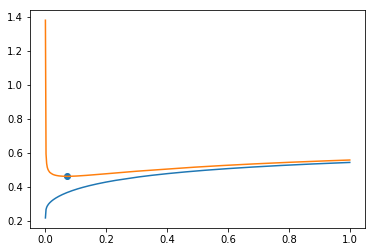

In [108]:
plt.plot(lamdas, Jtrain, lamdas, Jcv)
ind = np.where(Jcv == np.amin(Jcv))
optLambda = lamdas[ind]
plt.scatter(optLambda, Jcv[ind])

In [66]:
accuracy(theta_scipy_reg, sk_X_test, sk_y_test, threshold=0.5)

0.7291666666666666

In [76]:
# from sklearn.linear_model import LogisticRegression
model_reg_cv = LogisticRegression(penalty="l2", C=10000, fit_intercept=False, multi_class='ovr')
clk = model_reg_cv.fit(sk_X_train, sk_y_train)
#print("> model_reg.intercept_", model_reg.intercept_)
#print("> model_reg.coef_", model_reg.coef_)
clk.score(sk_X_test, sk_y_test)
#cost_function_reg(model_reg.coef_.T, X_train_poly, y_train_02, 1 / 10000)

0.7291666666666666

In [79]:
scores = cross_val_score(clk, X_train_poly, y_train_02, cv=5)
print(scores)

[0.875      0.45833333 0.75       0.60869565 0.73913043]


In [80]:
print("Accuracy : %0.2f (+/- %0.2f)" %(scores.mean(), scores.std() * 2)  )

Accuracy : 0.69 (+/- 0.28)


    Test by sklearn.dataset.load_iris

In [81]:
from sklearn.datasets import load_iris

In [83]:
data_iris = load_iris()

In [88]:
data = data_iris.data
target = data_iris.target

In [90]:
data_iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [93]:
data.shape

(150, 4)

In [94]:
target.shape

(150,)

In [97]:
lamd = 1
theta = np.zeros((data.shape[1], ))
res = scipy_opt_minimize_reg(theta, data, target, "tnc", lamd)
print(res)

print()
print(cost_function_reg(theta, data, target, lamd))

{'result':      fun: -inf
     jac: array([-3.29380723, -1.53208897, -2.69749996, -0.97381368])
 message: 'Linear search failed'
    nfev: 72
     nit: 1
  status: 4
 success: False
       x: array([-1.63626388, -4.52093937,  7.8444085 ,  3.91778037]), 'theta': array([-1.63626388, -4.52093937,  7.8444085 ,  3.91778037])}

0.6931471805599453


/home/local/SPREADTRUM/xing.jian/Public/Soft/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
